In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import obspy
from obspy.clients.fdsn import Client

c = Client("IRIS")

In [3]:
file = 'USArray_07-13.zip'
df = pd.read_pickle(file)

In [4]:
def download_waveforms(time, sta, pre, post, fs=40, client=c):
    ''' 
    Download a waveform window around a specific timestamp
    time: timestamp of arrival in yyyy-mm-dd HH:mm:ss.ff
    sta:  seismic station name
    pre:  window length prior to arrival in seconds
    post: window length after arrival in seconds
    '''
    
    time = obspy.UTCDateTime(time)
    st_time = time - pre
    en_time = time + post
    
    try:
        arrival_window = client.get_waveforms(network="*", location="",
                                                   station=sta, channel="BHZ",
                                                   starttime=st_time, endtime=en_time)[0]
    except:
        pass
    
    if len(arrival_window) != (pre + post) * fs:
        arrival_window = None
    
    return arrival_window

In [25]:
save_interval = 10

my_df = df[df.DIST < 5].sample(100).reset_index(drop=True)

pre_win   = 0  # window length prior to arrival in seconds
post_win  = 120  # window length after arrival in seconds
samp_rate = 40  # sample rate in hertz
     
dat = []
for row, arrival in my_df.iterrows():

    print(f'{row:05d}: \t {arrival.STA} \t {arrival.TIME}', end='... ')

    arrival_window = download_waveforms(arrival.TIME, arrival.STA, pre=pre_win, post=post_win, fs=samp_rate)
    if arrival_window: 
        dat.append(arrival_window)
        print('downloaded!')
    else:
        print('failed!')
        
    if row%save_interval == (save_interval-1):
        print(f'\nSaving {row+1} Rows of waveforms!\n')
        np.save('seismic_waveforms.npy', np.vstack(dat))

np.save('seismic_waveforms.npy', np.vstack(dat))

00000: 	 ISA 	 2007-06-04 08:15:39.650000... downloaded!
00001: 	 Z39A 	 2011-09-22 23:33:18.530000... downloaded!
00002: 	 W13A 	 2007-04-04 11:27:56.750000... failed!
00003: 	 W38A 	 2011-03-09 22:18:12.960000... downloaded!
00004: 	 L19A 	 2008-01-20 19:05:55.390000... downloaded!
00005: 	 VES 	 2011-09-14 14:45:30.620000... downloaded!
00006: 	 D37A 	 2010-12-10 18:39:06.270000... downloaded!
00007: 	 IBP 	 2011-04-08 23:42:41.760000... downloaded!
00008: 	 P15A 	 2008-02-22 17:32:25.090000... downloaded!
00009: 	 O07A 	 2008-02-21 15:35:14.920000... downloaded!

Saving 9 Rows of waveforms!

00010: 	 113A 	 2010-03-27 15:05:34.700000... failed!
00011: 	 RLMT 	 2010-11-24 18:21:33.900000... downloaded!
00012: 	 PFO 	 2008-05-02 04:04:18.120000... downloaded!
00013: 	 TUQ 	 2013-11-01 06:20:43.280000... downloaded!
00014: 	 D03A 	 2007-11-27 06:18:44.750000... downloaded!
00015: 	 N23A 	 2013-06-16 18:07:28.370000... downloaded!
00016: 	 WUAZ 	 2010-08-17 02:15:21.020000... downloade

In [26]:
dat = np.load('seismic_waveforms.npy')

In [27]:
def gap_generator(dat, bs, win_len, gap_len, fs):
    ''' 
    Build a batch of waveforms with gaps
    data:    numpy array with raw data
    bs:      batch size to be generated
    win_len: window length of each example in seconds
    gap_len: gap length in seconds
    fs:      sample rate of signal in hertz
    '''
    tot_len = dat.shape[1]
    dat = dat - np.expand_dims(np.mean(dat,axis=1),1)
    dat = dat / np.expand_dims(np.max(dat,axis=1),1)
    while 1:
        
        my_indicies = np.random.randint(len(dat), size=bs)
        my_win_st = np.random.randint(tot_len - win_len * fs)
        my_win_en = my_win_st + win_len * fs
        my_y = dat[my_indicies, my_win_st:my_win_en]

        my_x = my_y.copy()
        my_gap_st = int((win_len - gap_len) * fs / 2)
        my_gap_en = my_gap_st + gap_len * fs
        my_x[:, my_gap_st:my_gap_en] = 0

        yield my_x, my_y

In [28]:
batch_size = 4
window_len = 30
gap_len = 1
NFFT = 256

trn_gen = gap_generator(dat, bs=batch_size, win_len=window_len, gap_len=gap_len, fs=samp_rate)

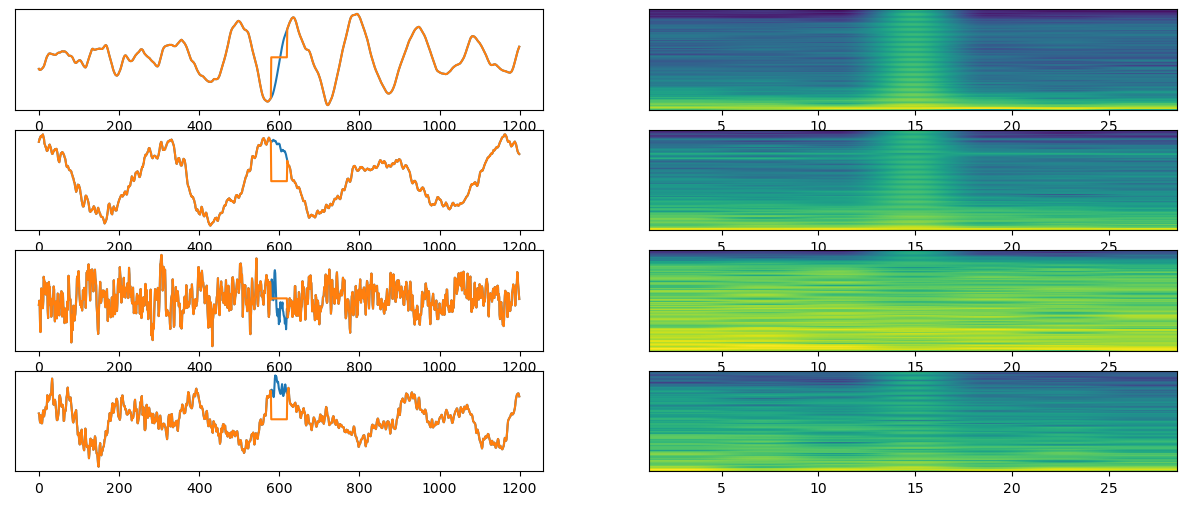

In [30]:
x, y = next(trn_gen)

fig, ax = plt.subplots(batch_size, 2, figsize=(15,batch_size*1.5))

for i in range(len(x)):
    ax[i,0].plot(y[i])
    ax[i,0].plot(x[i])
    ax[i,0].get_yaxis().set_ticks([])
    ax[i,1].specgram(x[i], NFFT=NFFT, Fs=samp_rate, noverlap=100)
    ax[i,1].get_yaxis().set_ticks([])

plt.savefig('gaps.jpg')
plt.show()